# 04 — Assignment Multi‑Objective Generation 

**What this notebook does**
- Lets you optimize **three properties at once** with a simple generator.
- Use the SELFIES‑based genetic algorithm is provided as a drop‑in alternative.

**Default properties (editable below)**
- Maximize **QED**
- Target **logP** within a range
- Target **TPSA** within a range

**Your tasks**
1. Choose your own three properties (and weights). You may plug in your **own model** for one of them (return a score in [0, 1]).  
2. Run the generator (SELFIES‑GA by default - but you can include your own model too).  
3. Compare outcomes vs. single‑objective runs and write up what you observe.


## 1) Setup

You can run with **just RDKit + SELFIES** you used in the previous notebook


In [1]:
# Imports and environment checks
import os, math, random, json
import numpy as np, pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import Crippen, rdMolDescriptors, Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import QED

import selfies as sf
from tqdm import trange, tqdm


In [2]:
# RDKit / SELFIES utils
def smiles_to_mol(s):
    try:
        m = Chem.MolFromSmiles(s)
        if m is None: 
            return None
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def morgan_fp(mol, radius=2, nbits=1024):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)

def tanimoto(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def to_selfies(smiles):
    try:
        return sf.encoder(smiles)
    except Exception:
        return None

def to_smiles(selfies_str):
    try:
        return sf.decoder(selfies_str)
    except Exception:
        return None

def heavy_atoms(mol):
    return int(mol.GetNumHeavyAtoms())

In [3]:
# 2) Property scorers
# All property functions must return a score in [0, 1].

def soft_range_score(x, low, high, sigma=5.0):
    """Score of 1 inside [low, high]; Gaussian decay outside with width sigma."""
    if x < low:
        return float(np.exp(-((low - x) ** 2) / (2 * sigma ** 2)))
    if x > high:
        return float(np.exp(-((x - high) ** 2) / (2 * sigma ** 2)))
    return 1.0

def score_qed(mol):
    try:
        return float(QED.qed(mol))  # already in [0,1]
    except Exception:
        return 0.0

def score_logp_in_range(mol, low=1.0, high=3.0, sigma=1.0):
    lp = Crippen.MolLogP(mol)
    return soft_range_score(lp, low, high, sigma=sigma)

def score_tpsa_in_range(mol, low=20.0, high=100.0, sigma=10.0):
    tpsa = rdMolDescriptors.CalcTPSA(mol)
    return soft_range_score(tpsa, low, high, sigma=sigma)

# 🔌 Hook: your own model as a scorer
# Replace the body to call your model and map its output to [0,1].
def score_custom_model(mol):
    # Example (placeholder): predict some value v in arbitrary range and map to [0,1]
    # v = my_model_predict(mol)
    # return float(1 / (1 + np.exp(-(v - v_center)/v_scale)))
    return 0.5  # <- EDIT ME if you add your own model

In [4]:
# 3) Combine three properties into a single objective
# Choose which three and their weights here.

PROPERTY_SETUPS = [
    { "name": "QED", "fn": score_qed, "weight": 0.4 },
    { "name": "logP[1,3]", "fn": lambda m: score_logp_in_range(m, low=1.0, high=3.0, sigma=1.0), "weight": 0.3 },
    { "name": "TPSA[20,100]", "fn": lambda m: score_tpsa_in_range(m, low=20.0, high=100.0, sigma=10.0), "weight": 0.3 },
]

# Alternative example with a custom model (uncomment and edit):
# PROPERTY_SETUPS = [
#     { "name": "QED", "fn": score_qed, "weight": 0.34 },
#     { "name": "CustomModel", "fn": score_custom_model, "weight": 0.33 },
#     { "name": "logP[0,2.5]", "fn": lambda m: score_logp_in_range(m, low=0.0, high=2.5, sigma=1.0), "weight": 0.33 },
# ]

def combine_scores(mol, property_setups=PROPERTY_SETUPS, mode="weighted_geometric"):
    vals = []
    weights = []
    for p in property_setups:
        v = float(p["fn"](mol))
        v = float(max(0.0, min(1.0, v)))
        vals.append(v)
        weights.append(float(p.get("weight", 1.0)))
    vals = np.array(vals, dtype=float)
    weights = np.array(weights, dtype=float)
    weights = weights / (weights.sum() if weights.sum() > 0 else 1.0)
    if mode == "weighted_sum":
        return float(np.dot(weights, vals)), vals, weights
    # Weighted geometric mean (penalizes low components)
    with np.errstate(divide='ignore'):
        log_vals = np.log(np.clip(vals, 1e-8, 1.0))
    score = float(np.exp(np.dot(weights, log_vals)))
    return score, vals, weights

In [5]:
# 4) Scoring function to combine scores - look at how this works and how you would amend it.

class LocalScoringFunction:  
    def __init__(self, setups):
        self.setups = setups
        self.names = [p["name"] for p in setups]
    def score(self, smiles_list):
        scores = []
        for s in smiles_list:
            mol = smiles_to_mol(s)
            if mol is None:
                scores.append(0.0)
                continue
            sc, _, _ = combine_scores(mol, self.setups)
            scores.append(sc)
        return scores


In [6]:
# 5) SELFIES-based GA  - you can insert your own model here - or change it.

ALPHABET = list(sf.get_semantic_robust_alphabet())
for tok in ["[C]","[c]","[O]","[N]","[=O]","[F]","[Cl]","[Br]","[S]"]:
    if tok not in ALPHABET:
        ALPHABET.append(tok)

def mutate_selfies(sf_str, n_mut=1):
    toks = list(sf.split_selfies(sf_str))
    if not toks:
        toks = ["[C]"]
    for _ in range(n_mut):
        op = random.choice(["insert","replace","delete"])
        if op == "delete" and len(toks) > 1:
            idx = random.randrange(len(toks))
            toks.pop(idx)
        elif op == "insert":
            idx = random.randrange(len(toks)+1)
            toks.insert(idx, random.choice(ALPHABET))
        else:  # replace
            idx = random.randrange(len(toks))
            toks[idx] = random.choice(ALPHABET)
    return "".join(toks)

def crossover_selfies(a, b):
    ta = list(sf.split_selfies(a)); tb = list(sf.split_selfies(b))
    if not ta: ta = ["[C]"]
    if not tb: tb = ["[C]"]
    i = random.randrange(1, len(ta)) if len(ta) > 1 else 1
    j = random.randrange(1, len(tb)) if len(tb) > 1 else 1
    child = "".join(ta[:i] + tb[j:])
    return child

class SelfiesGA:
    def __init__(self, population_size=200, elite_fraction=0.2, mutation_rate=0.7, n_mutations=1, crossover_rate=0.3, seed_smiles=None, random_seed=0):
        self.population_size = population_size
        self.elite_fraction = elite_fraction
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.n_mutations = n_mutations
        random.seed(random_seed); np.random.seed(random_seed)
        self.seed_smiles = seed_smiles or ["CCO","c1ccccc1","CC(=O)OC1=CC=CC=C1C(=O)O"]

    def _init_population(self):
        pop = []
        # start from SELFIES of seeds + mutations
        seed_sf = [to_selfies(s) for s in self.seed_smiles if to_selfies(s)]
        while len(pop) < self.population_size:
            parent = random.choice(seed_sf) if seed_sf else "[C][C][O]"
            child = mutate_selfies(parent, n_mut=1)
            pop.append(child)
        return pop

    def generate(self, scoring_fn, generations=80, patience=15):
        # scoring_fn: ThreePropScoringFunction-like with .score(smiles_list)->list[float]
        population = self._init_population()
        best = {"score": -1, "smiles": None}
        trace = []

        def score_selfies_list(sf_list):
            smiles = []
            for s in sf_list:
                sm = to_smiles(s)
                if not sm or smiles_to_mol(sm) is None:
                    smiles.append(None)
                else:
                    smiles.append(sm)
            scores = scoring_fn.score([s if s is not None else "" for s in smiles])
            return smiles, scores

        no_improve = 0
        for gen in trange(generations, desc="GA"):
            smiles, scores = score_selfies_list(population)
            ranked = list(zip(scores, population, smiles))
            ranked = [r for r in ranked if r[2] is not None]
            if not ranked:
                population = self._init_population()
                continue
            ranked.sort(key=lambda x: x[0], reverse=True)
            elite_n = max(1, int(self.elite_fraction * len(ranked)))
            elites = [r[1] for r in ranked[:elite_n]]

            # Track best
            if ranked[0][0] > best["score"]:
                best = {"score": float(ranked[0][0]), "smiles": ranked[0][2]}
                no_improve = 0
            else:
                no_improve += 1

            trace.append({"generation": gen, "best_score": float(ranked[0][0]), "best_smiles": ranked[0][2]})

            if no_improve >= patience:
                break

            # Produce offspring
            new_pop = elites.copy()
            while len(new_pop) < self.population_size:
                if random.random() < self.crossover_rate and len(elites) >= 2:
                    pa, pb = random.sample(elites, 2)
                    child = crossover_selfies(pa, pb)
                else:
                    pa = random.choice(elites)
                    child = pa
                if random.random() < self.mutation_rate:
                    child = mutate_selfies(child, n_mut=self.n_mutations)
                new_pop.append(child)
            population = new_pop[:self.population_size]

        return best, trace

In [8]:
# 6) Load seeds and run a 3-property optimization
DATA_DIR = os.path.join("..","data")
OUT_DIR = os.path.join("..","outputs")
os.makedirs(OUT_DIR, exist_ok=True)

seeds_df = pd.read_csv(os.path.join(DATA_DIR, "seed_smiles.csv"))
seed_smiles = seeds_df["smiles"].tolist()

scoring = LocalScoringFunction(PROPERTY_SETUPS)

ga = SelfiesGA(population_size=200, elite_fraction=0.2, mutation_rate=0.7, n_mutations=1, crossover_rate=0.3,
               seed_smiles=seed_smiles, random_seed=7)
best, trace = ga.generate(scoring, generations=100, patience=20)

# Save trace and top 50 unique by score (re-evaluated)
# Re-evaluate combined score and component scores for saved molecules
def evaluate_smiles_list(smiles_list):
    rows = []
    for smi in smiles_list:
        mol = smiles_to_mol(smi)
        if not mol:
            continue
        score, vals, weights = combine_scores(mol, PROPERTY_SETUPS)
        row = {"smiles": smi, "score": score}
        for name, v in zip([p["name"] for p in PROPERTY_SETUPS], vals):
            row[name] = float(v)
        rows.append(row)
    return pd.DataFrame(rows)

# Build candidate set from trace + seeds
cand = [r.get("best_smiles") for r in trace if r.get("best_smiles")]
# add more by mutating best a few times to diversify
if best.get("smiles"):
    for _ in range(200):
        s = to_selfies(best["smiles"]) or "[C][C]"
        cand.append(to_smiles(mutate_selfies(s)))

df = evaluate_smiles_list(list(dict.fromkeys([c for c in cand if c])))
df = df.sort_values("score", ascending=False)
top = df.head(50)
top_path = os.path.join(OUT_DIR, "multiobj_top50.csv")
trace_path = os.path.join(OUT_DIR, "multiobj_trace.csv")
top.to_csv(top_path, index=False)
pd.DataFrame(trace).to_csv(trace_path, index=False)

print("Saved:", top_path, "and", trace_path)
best

GA:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 76/100 [00:09<00:03,  7.97it/s]


Saved: ../outputs/multiobj_top50.csv and ../outputs/multiobj_trace.csv


{'score': 0.9777346145374403,
 'smiles': 'C#[N+1]C(C)C1=CC2=[B-1](C=C13)C2=CC(=O)C3C(C)=C[N+1]C(=O)O'}

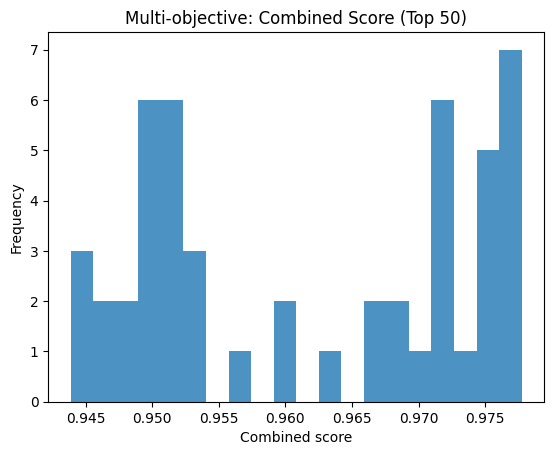

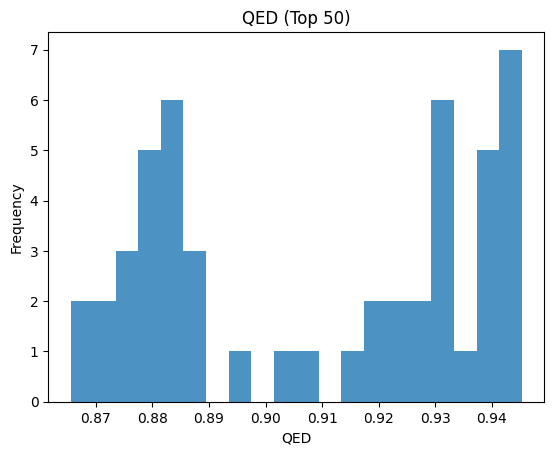

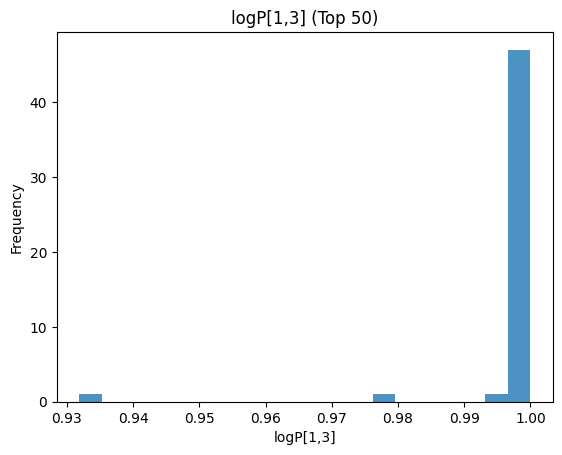

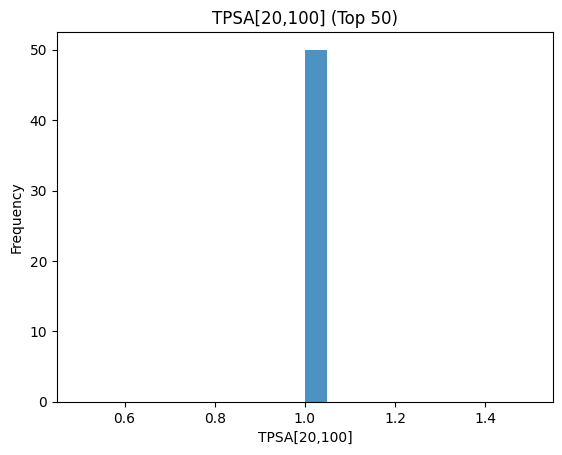

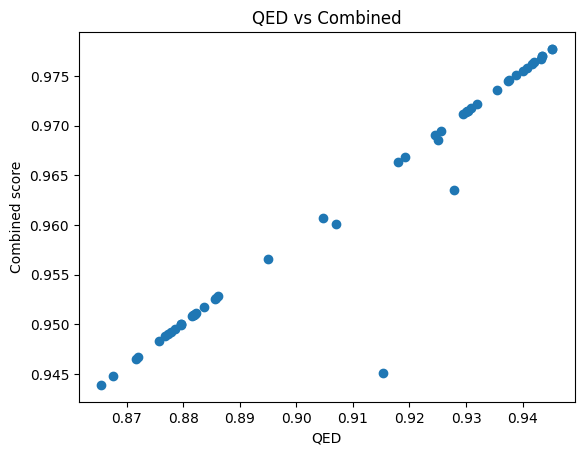

In [9]:
# 7) Quick plots (matplotlib only)
import matplotlib.pyplot as plt
from math import ceil

# Combined score histogram
plt.figure()
top = pd.read_csv(os.path.join(OUT_DIR, "multiobj_top50.csv"))
top["score"].plot(kind="hist", bins=20, alpha=0.8, title="Multi-objective: Combined Score (Top 50)")
plt.xlabel("Combined score")
plt.show()

# Per-property histograms
prop_names = [p["name"] for p in PROPERTY_SETUPS]
for prop in prop_names:
    plt.figure()
    top[prop].plot(kind="hist", bins=20, alpha=0.8, title=f"{prop} (Top 50)")
    plt.xlabel(prop)
    plt.show()

# Scatter: one property vs combined score
plt.figure()
plt.scatter(top[prop_names[0]], top["score"])
plt.xlabel(prop_names[0]); plt.ylabel("Combined score")
plt.title(f"{prop_names[0]} vs Combined")
plt.show()

## 8) What to include in your report
- **Describe your three properties** (and why you chose them). Include the weighting scheme and shaping functions.
- **Show distributions** for the combined score and each property (histograms) and at least one scatter plot.
- **Discuss trade-offs** you observed (e.g., increased QED vs. worse TPSA).
- **Reflect on limitations**: multi-objective weighting sensitivity, mode collapse, over-optimization to any surrogate, and why single numbers are reductive.